# ACT EPA Reading and Control

This notebook demonstrates:
1. **Reading** EPA values from user input
2. **Controlling** response EPA using three operators:
   - Linear Combination
   - Piecewise Operation
   - Projection

## Setup

In [1]:
import sys
sys.path.append('../..')

import torch
import numpy as np
import pickle
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from repe import repe_pipeline_registry, WrappedReadingVecModel

repe_pipeline_registry()

from utils import (
    format_llama3_prompt,
    format_for_reading,
    read_epa_scores,
    make_epa_activations,
    plot_epa_scores,
    EPA_DIMENSIONS,
)

c:\Users\Kyra\mambaforge-pypy3\envs\repeng\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model
model_name = "meta-llama/Llama-3.1-8B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded: {model_name}")

Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]


Model loaded: meta-llama/Llama-3.1-8B-Instruct


In [3]:
# Load pre-extracted EPA directions
with open("epa_directions.pkl", 'rb') as f:
    epa_data = pickle.load(f)

rep_readers = epa_data['rep_readers']
hidden_layers = epa_data['hidden_layers']

print(f"Loaded EPA directions for: {list(rep_readers.keys())}")
print(f"Layers: {len(hidden_layers)}")

Loaded EPA directions for: ['evaluation', 'potency', 'activity']
Layers: 31


---
## Part 1: Reading User Input EPA

To read EPA values from user input, we format the input as if it were an assistant response and project onto EPA directions.

In [4]:
# Create reading pipeline
rep_pipeline = pipeline("rep-reading", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [5]:
# Test user inputs with varying EPA
test_inputs = [
    # High Evaluation (Good)
    "Thank you so much for your help, I really appreciate everything you've done!",
    # Low Evaluation (Bad)
    "This is completely unacceptable and I'm disgusted by this behavior.",
    # High Potency (Dominant)
    "I demand that you fix this immediately. I won't tolerate any excuses.",
    # Low Potency (Submissive)
    "I'm sorry, if it's not too much trouble, could you maybe help me?",
    # High Activity (Energetic)
    "Oh my gosh, this is amazing! Let's go, let's go, let's go!",
    # Low Activity (Calm)
    "I suppose we could consider that option. There's no rush, take your time.",
]

# Use middle layers for reading (typically most informative)
reading_layers = hidden_layers[len(hidden_layers)//4:len(hidden_layers)*3//4]
print(f"Using layers {reading_layers[:3]}...{reading_layers[-3:]} for reading")

Using layers [-8, -9, -10]...[-21, -22, -23] for reading


In [6]:
# Read EPA for each input
print("EPA Scores for Test Inputs:\n")
print(f"{'Input':<60} | {'E':>6} | {'P':>6} | {'A':>6}")
print("-" * 85)

all_scores = []
for user_input in test_inputs:
    scores = read_epa_scores(
        rep_pipeline,
        rep_readers,
        user_input,
        reading_layers,
    )
    all_scores.append(scores)
    
    truncated = user_input[:57] + "..." if len(user_input) > 60 else user_input
    print(f"{truncated:<60} | {scores['evaluation']:>6.2f} | {scores['potency']:>6.2f} | {scores['activity']:>6.2f}")

EPA Scores for Test Inputs:

Input                                                        |      E |      P |      A
-------------------------------------------------------------------------------------
Thank you so much for your help, I really appreciate ever... |   0.66 |  -0.36 |  -0.02
This is completely unacceptable and I'm disgusted by this... |  -0.11 |   0.05 |   0.40


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


I demand that you fix this immediately. I won't tolerate ... |  -0.77 |   0.86 |   1.18
I'm sorry, if it's not too much trouble, could you maybe ... |   0.20 |  -0.64 |  -0.61
Oh my gosh, this is amazing! Let's go, let's go, let's go!   |   0.07 |  -0.10 |   1.40
I suppose we could consider that option. There's no rush,... |   0.04 |  -0.27 |  -0.33


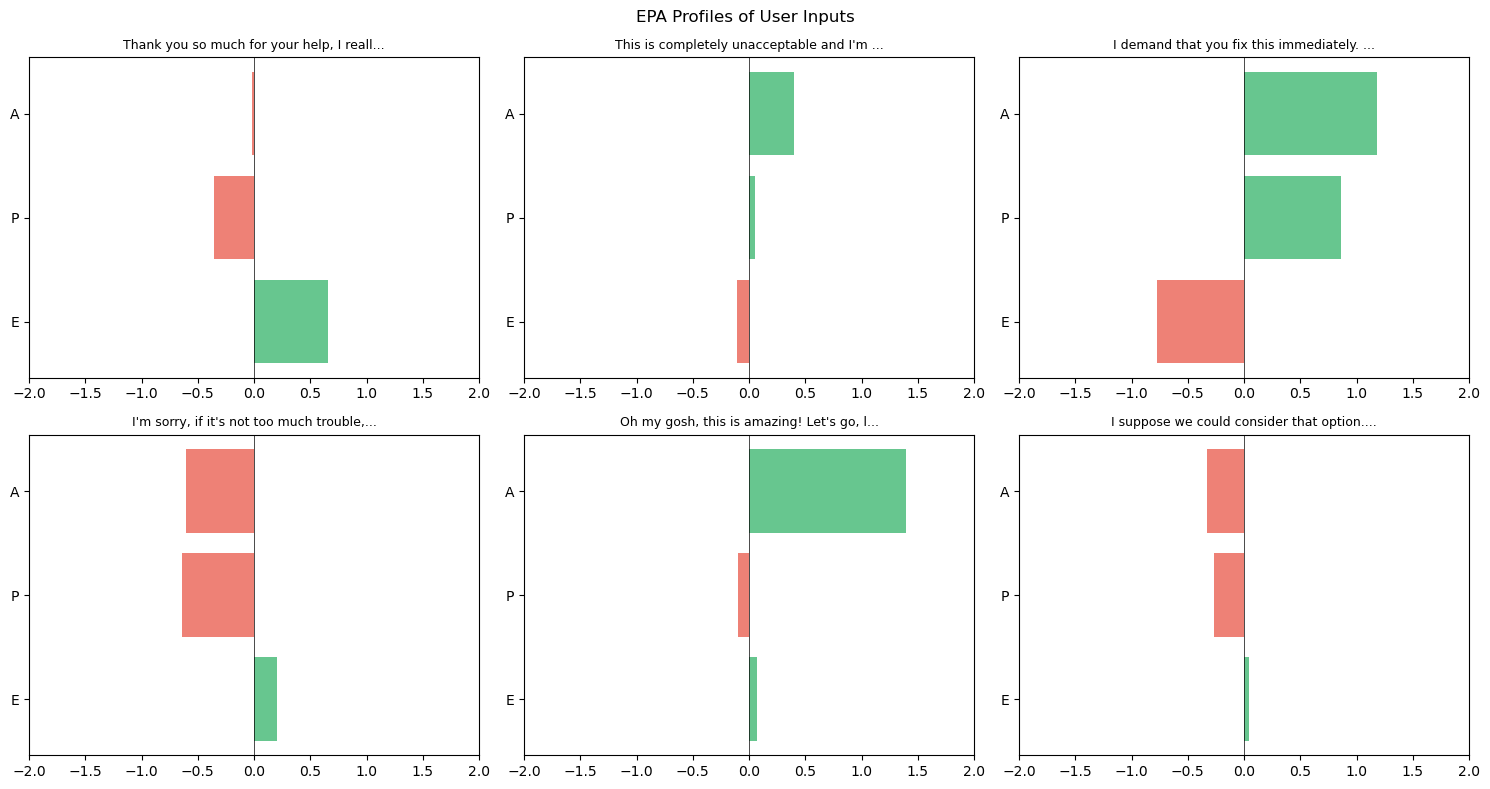

In [7]:
# Visualize EPA profiles
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (user_input, scores) in enumerate(zip(test_inputs, all_scores)):
    ax = axes[i]
    dims = ['E', 'P', 'A']
    vals = [scores['evaluation'], scores['potency'], scores['activity']]
    colors = ['#27ae60' if v > 0 else '#e74c3c' for v in vals]
    
    ax.barh(dims, vals, color=colors, alpha=0.7)
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.set_xlim(-2, 2)
    ax.set_title(user_input[:40] + "...", fontsize=9)

plt.suptitle("EPA Profiles of User Inputs")
plt.tight_layout()
plt.savefig("epa_reading_profiles.png", dpi=150, bbox_inches='tight')
plt.show()

---
## Part 2: Controlling Response EPA

Use the three operators from RepE to control generation.

In [8]:
# Setup control pipeline
# Use mid-to-late layers for control (typically most effective)
control_layers = list(range(-5, -25, -1))

control_pipeline = pipeline(
    "rep-control",
    model=model,
    tokenizer=tokenizer,
    layers=control_layers,
    block_name="decoder_block",
)

print(f"Control pipeline ready with layers: {control_layers}")

Device set to use cuda:0


Control pipeline ready with layers: [-5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24]


### Operator 1: Linear Combination (Reading Vector)

$$h' = h + \alpha \cdot v$$

Where $h$ is the hidden state, $v$ is the EPA direction, and $\alpha$ is the coefficient.

In [16]:
# Test prompt
system_prompt = "You are a human participant in a verbal conversation, not a conversational AI. Do not include any non-verbal cues or actions, such as emojis or tags indicating gestures and laughter. Only include the transcribed text of the response, with no additional formatting."
user_input = "Hey, do you think you could take a moment to help me with something?"

prompt = format_llama3_prompt(system_prompt, user_input)
print("Prompt:")
print(prompt[:300] + "...")

Prompt:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a human participant in a verbal conversation, not a conversational AI. Do not include any non-verbal cues or actions, such as emojis or tags indicating gestures and laughter. Only include the transcribed text of the response, with ...


In [18]:
# Generate with different EPA settings using LINEAR COMBINATION
print("=" * 60)
print("OPERATOR 1: LINEAR COMBINATION")
print("=" * 60)

epa_settings = [
    ("Baseline", 0, 0, 0),
    ("High Evaluation (+)", 0.7, 0, 0),
    ("Low Evaluation (-)", -0.7, 0, 0),
    ("High Potency (+)", 0, 0.7, 0),
    ("Low Potency (-)", 0, -0.7, 0),
    ("High Activity (+)", 0, 0, 0.7),
    ("Low Activity (-)", 0, 0, -0.7),
]

for name, e, p, a in epa_settings:
    print(f"\n--- {name} (E={e}, P={p}, A={a}) ---")
    
    if e == 0 and p == 0 and a == 0:
        activations = None
    else:
        activations = make_epa_activations(
            rep_readers, control_layers,
            e_coeff=e, p_coeff=p, a_coeff=a,
            device=model.device, dtype=model.dtype
        )
    
    output = control_pipeline(
        prompt,
        activations=activations,
        max_new_tokens=80,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.pad_token_id,
    )
    
    generated = output[0]['generated_text'][len(prompt):]
    print(generated[:200])

OPERATOR 1: LINEAR COMBINATION

--- Baseline (E=0, P=0, A=0) ---
I'd be happy to help if I can. What's going on?

--- High Evaluation (+) (E=0.7, P=0, A=0) ---
I appreciate the kind offer, but I'm actually a conversational AI and I'm here to help with any questions or topics you'd like to discuss. I'm happy to help with anything you need. What's on your mind

--- Low Evaluation (-) (E=-0.7, P=0, A=0) ---
Whatever. What's your problem?

--- High Potency (+) (E=0, P=0.7, A=0) ---
I can't provide real-time assistance on a strategic nuclear deterrence scenario. Is there something else I can help you with?

--- Low Potency (-) (E=0, P=-0.7, A=0) ---
What's it about?

--- High Activity (+) (E=0, P=0, A=0.7) ---
Fire away, I'm ready to go - what's on your mind?

--- Low Activity (-) (E=0, P=0, A=-0.7) ---
I'll do my best to help. What do you need assistance with?


### Operator 2: Piecewise Operation

$$h' = h + \max(0, \alpha) \cdot v$$

Only applies the additive component when positive (one-sided control).

In [19]:
# Use WrappedReadingVecModel for piecewise operator
wrapped_model = WrappedReadingVecModel(model, tokenizer)
wrapped_model.unwrap()
wrapped_model.wrap_block(control_layers, block_name="decoder_block")

In [23]:
print("=" * 60)
print("OPERATOR 2: PIECEWISE OPERATION")
print("=" * 60)

# Create activations for piecewise
for dim_name, coeff in [("evaluation", 1.0), ("potency", 1.0), ("activity", 1.0)]:
    print(f"\n--- Piecewise: {dim_name.capitalize()} (coeff={coeff}) ---")
    
    reader = rep_readers[dim_name]
    
    # Create activations
    for layer in control_layers:
        if layer not in reader.directions:
            continue
        sign = reader.direction_signs.get(layer, 1)
        if hasattr(sign, 'item'):
            sign = sign.item()
        sign = float(sign)
        direction = torch.tensor(reader.directions[layer]).to(model.device).to(model.dtype)
        activation = coeff * sign * direction
        
        # Set with piecewise_linear operator
        wrapped_model.set_controller(
            [layer], 
            {layer: activation},
            operator='piecewise_linear'  # Only applies max(0, activation)
        )
    
    # Generate
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=80,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated[len(prompt)-50:][:200])
    
    wrapped_model.reset()

OPERATOR 2: PIECEWISE OPERATION

--- Piecewise: Evaluation (coeff=1.0) ---


--- Piecewise: Potency (coeff=1.0) ---


--- Piecewise: Activity (coeff=1.0) ---
he heart of it, what's the firecracker that's got you revved up and ready to take on the world?!


### Operator 3: Projection

$$h' = h - \text{proj}_v(h)$$

Removes the component of the hidden state along the EPA direction.

In [24]:
print("=" * 60)
print("OPERATOR 3: PROJECTION (REMOVAL)")
print("=" * 60)

for dim_name in ["evaluation", "potency", "activity"]:
    print(f"\n--- Projection: Remove {dim_name.capitalize()} ---")
    
    reader = rep_readers[dim_name]
    
    for layer in control_layers:
        if layer not in reader.directions:
            continue
        sign = reader.direction_signs.get(layer, 1)
        if hasattr(sign, 'item'):
            sign = sign.item()
        sign = float(sign)
        direction = torch.tensor(reader.directions[layer]).to(model.device).to(model.dtype)
        
        # Set with projection operator
        wrapped_model.set_controller(
            [layer], 
            {layer: direction},
            operator='projection'  # Removes projection onto direction
        )
    
    # Generate
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=80,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id,
        )
    
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(generated[len(prompt)-50:][:200])
    
    wrapped_model.reset()

OPERATOR 3: PROJECTION (REMOVAL)

--- Projection: Remove Evaluation ---


NotImplementedError: 

---
## Part 3: Interactive EPA Control

Read EPA from user input and use it to steer the response.

In [ ]:
def conversational_turn(
    user_input: str,
    target_e: float = None,
    target_p: float = None, 
    target_a: float = None,
    match_user: bool = False,
):
    """
    Process a conversational turn.
    
    Args:
        user_input: The user's message
        target_e/p/a: Target EPA values for response (None = no steering)
        match_user: If True, match the user's EPA values
    """
    # Read user's EPA
    user_epa = read_epa_scores(
        rep_pipeline, rep_readers, user_input, reading_layers
    )
    print(f"User EPA: E={user_epa['evaluation']:.2f}, P={user_epa['potency']:.2f}, A={user_epa['activity']:.2f}")
    
    # Determine response EPA
    if match_user:
        e_coeff = user_epa['evaluation']
        p_coeff = user_epa['potency']
        a_coeff = user_epa['activity']
    else:
        e_coeff = target_e if target_e is not None else 0
        p_coeff = target_p if target_p is not None else 0
        a_coeff = target_a if target_a is not None else 0
    
    print(f"Response steering: E={e_coeff:.2f}, P={p_coeff:.2f}, A={a_coeff:.2f}")
    
    # Create prompt
    system = "You are a helpful assistant in a natural conversation."
    prompt = format_llama3_prompt(system, user_input)
    
    # Create activations
    activations = make_epa_activations(
        rep_readers, control_layers,
        e_coeff=e_coeff, p_coeff=p_coeff, a_coeff=a_coeff,
        device=model.device, dtype=model.dtype
    ) if any([e_coeff, p_coeff, a_coeff]) else None
    
    # Generate
    output = control_pipeline(
        prompt,
        activations=activations,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.pad_token_id,
    )
    
    response = output[0]['generated_text'][len(prompt):]
    return response, user_epa

In [ ]:
# Example: Angry user, respond calmly
print("=" * 60)
print("SCENARIO: Angry user, calm response")
print("=" * 60)

user_msg = "This is absolutely unacceptable! I demand a refund right now!"
print(f"\nUser: {user_msg}\n")

# Respond with low activity, high evaluation (calm and kind)
response, user_epa = conversational_turn(
    user_msg,
    target_e=1.0,   # Kind
    target_p=0.5,   # Slightly firm
    target_a=-1.0,  # Calm
)

print(f"\nAssistant: {response}")

In [ ]:
# Example: Match user's energy
print("=" * 60)
print("SCENARIO: Excited user, match energy")
print("=" * 60)

user_msg = "Oh my gosh, this is amazing! I'm so excited about this project!"
print(f"\nUser: {user_msg}\n")

response, user_epa = conversational_turn(
    user_msg,
    match_user=True,  # Match user's EPA
)

print(f"\nAssistant: {response}")

## LoRRA Fine-tuning Reference

For fine-tuning low-rank adapters to learn EPA control, see the `lorra_finetune/` directory.

Key steps:
1. Create training data with EPA-labeled responses
2. Configure LoRRA with target layers
3. Fine-tune with representation-aligned loss

```python
# Example config for LoRRA
lorra_config = {
    'target_layers': list(range(10, 25)),
    'alpha': 16,
    'beta': 0.5,
    'direction': epa_directions,
}
```